In [6]:
v = gen_perm_mat(10)

In [12]:
v

array([[9., 2., 6., 4., 7., 3., 8., 0., 5., 1.],
       [4., 3., 5., 8., 6., 9., 0., 7., 2., 1.],
       [8., 4., 2., 3., 1., 0., 6., 7., 5., 9.],
       [3., 6., 1., 8., 4., 5., 0., 2., 7., 9.],
       [5., 4., 1., 9., 2., 8., 6., 3., 0., 7.],
       [1., 4., 0., 8., 9., 7., 2., 3., 5., 6.],
       [2., 3., 4., 1., 7., 9., 8., 6., 0., 5.],
       [7., 9., 4., 8., 1., 0., 3., 2., 6., 5.],
       [8., 0., 9., 3., 4., 2., 7., 5., 1., 6.],
       [2., 0., 3., 6., 7., 4., 5., 9., 8., 1.]])

In [11]:
gen_choiceset_clique(v, 10, 2)

array([[2., 3.],
       [3., 2.],
       [8., 6.],
       [6., 8.],
       [9., 0.],
       [0., 9.],
       [4., 5.],
       [4., 5.],
       [7., 1.],
       [7., 1.]])

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def gen_perm_mat(n):
    """ n by n matrix where each row is a permutation """
    u = np.zeros((n,n))
    for i in range(n):
        u[i, ] = np.random.permutation(range(n))
    return u

def gen_choiceset_match(v_mat, n, k):
    """ take permutation matrix, 
    form k unif random matchings and 
    provide each individual with the choice set of people who they showed up in matchings with.
    entry i,j is individual i's j-th preference """
    v = np.zeros((n, k))
    choice_sets = np.zeros((n, k))
    for i in range(k):
        choice_sets[:,i] = np.random.permutation(range(n))
    for i in range(n):
        k_ind = 0
        for j in range(n):
            if v_mat[i][j] in choice_sets[i,]:
                v[i, k_ind] = v_mat[i][j]
                k_ind += 1
    return v

def gen_choiceset_clique(v_mat, n, k):
    """
        input: permutation matrix
        output: choice sets that consist of k-cliques
    """
    choice_sets = np.zeros((n, k))
    ordered_choice_sets = np.zeros((n,k))
    ranks = np.random.permutation(range(n))
    # iterate over choice set cliques
    for i in range(n // k):
        # iterate over members of the choice set clique
        for j in range(k):
            if i*k +j >= n:
                continue
            # iterate over firms with the same clique
            for l in range(k):
                if i*k + l >= n:
                    continue
                choice_sets[i*k + l,j] = ranks[k*i + j]
    for i in range(n):
        k_ind = 0
        for j in range(n):
            if v_mat[i][j] in choice_sets[i,]:
                ordered_choice_sets[i, k_ind] = v_mat[i][j]
                k_ind += 1
    return ordered_choice_sets

def gen_choiceset_identity(v_mat, n, k):
    """
        input: permutation matrix
        output: choice sets that consist of the full choice set
    """
    return v_mat
    

def gen_rank_dict(u):
    """ input: permutation matrix 
        output: for seeker i and firm j, what is rank_i(j)
    """
    d = dict()
    for i in range(u.shape[0]):
        for j in range(u.shape[1]):
            if not i in d:
                d[i] = dict()
            d[i][u[i,j]] = j
    return d

# Goal: under random matchings-based choice sets, is there a curse of k>=2 choices?
def jobs_propose(u_dict, v_mat, k):
    """ u is the dict of preferences of candidates, v is preferences of firms, k is the size of each firm's preference list """
    n = len(v_mat)
    v_match = np.array([-1] * n)
    u_match = np.array([-1] * n)
    next_proposal_ind = np.array([0] * n)
    # while all the people who are unmatched have someone left to propose to
    while True:
        unmatched = v_match == -1
        more_proposees = next_proposal_ind != k
        if not np.any(unmatched & more_proposees):
            break
        # iterate over jobs
        for i in range(n):
            if v_match[i] != -1:
                continue
            # iterate through their preferences
            for j in range(next_proposal_ind[i], k):
                proposee = int(v_mat[i][j])
                next_proposal_ind[i] = j
                if u_match[proposee] == -1:
                    u_match[proposee] = i
                    v_match[i] = proposee
                    break
                elif (u_dict[proposee][i] < u_dict[proposee][u_match[proposee]]):
                    rejectee = u_match[proposee]
                    u_match[proposee] = i
                    v_match[i] = proposee
                    v_match[rejectee] = -1
                    break
                if j == k-1:
                    next_proposal_ind[i] = k
                
    return u_match, v_match
            


In [31]:
def sample_match_val(n, k, unmatched_cost, gen_choiceset):
    u_mat = gen_perm_mat(n)
    u_dict = gen_rank_dict(u_mat)
    v_mat = gen_perm_mat(n)
    v_choiceset = gen_choiceset(v_mat, n, k)
    v_dict = gen_rank_dict(v_mat)
    u_match, v_match = jobs_propose(u_dict, v_choiceset, k)
    v_ranks = np.array([v_dict[i][int(j)] if j != -1 else unmatched_cost for i, j in enumerate(v_match)])
    avg_match_val = np.mean(n - v_ranks) / (n+1)
    return avg_match_val

def prop_unmatched(n, k, gen_choiceset):
    u_mat = gen_perm_mat(n)
    u_dict = gen_rank_dict(u_mat)
    v_mat = gen_perm_mat(n)
    v_choiceset = gen_choiceset(v_mat, n, k)
    v_dict = gen_rank_dict(v_mat)
    u_match, v_match = jobs_propose(u_dict, v_choiceset, k)
    prop_um = np.sum(v_match == -1) / n
    return prop_um

def plot_sims(unmatched_cost):
    sims_match = np.zeros((N, K))
    sims_clique = np.zeros((N, K))
    # iterate through choice set of size k
    for k in range(1, K):
        sims_match[:,k-1] = [sample_match_val(n, k, unmatched_cost, gen_choiceset_match) for _ in range(N)]
        sims_clique[:,k-1] = [sample_match_val(n, k, unmatched_cost, gen_choiceset_clique) for _ in range(N)]
    avgs_match = [np.mean(sims_match[:,k]) for k in range(K-1)]
    sds_match = [np.std(sims_match[:,k]) for k in range(K-1)]
    avgs_clique = [np.mean(sims_clique[:,k]) for k in range(K-1)]
    sds_clique = [np.std(sims_clique[:,k]) for k in range(K-1)]
    fig, ax = plt.subplots()
    ax.errorbar(range(1, K), avgs_match, yerr=sds_match, label="random match")
    ax.errorbar(range(1, K), avgs_clique, yerr=sds_clique, label="random clique")
    ax.set_xlabel("Max choice set size (k)")
    ax.set_ylabel("Average match value")
    ax.legend()

def plot_unmatched():
    sims_match = np.zeros((N, K))
    # iterate through choice set of size k
    for k in range(1, K):
        sims_match[:,k-1] = [prop_unmatched(n, k, gen_choiceset_match) for _ in range(N)]
    avgs_match = [np.mean(sims_match[:,k]) for k in range(K-1)]
    sds_match = [np.std(sims_match[:,k]) for k in range(K-1)]
    fig, ax = plt.subplots()
    ax.errorbar(range(1, K), avgs_match, yerr=sds_match, label="random match")
    ax.set_xlabel("Max choice set size (k)")
    ax.set_ylabel("Proportion unmatched")
    ax.legend()
    

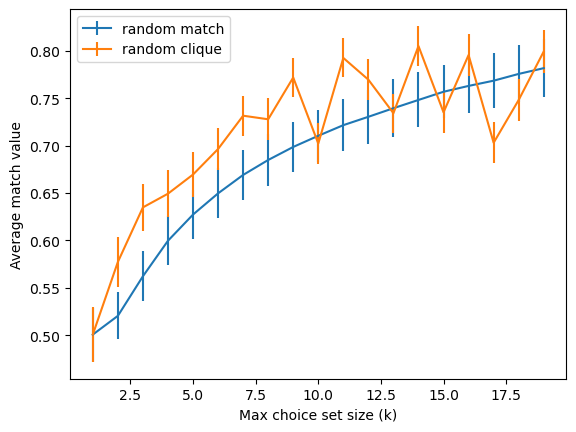

In [34]:
n = 99
N = 1000
K = 20

plot_sims(n)

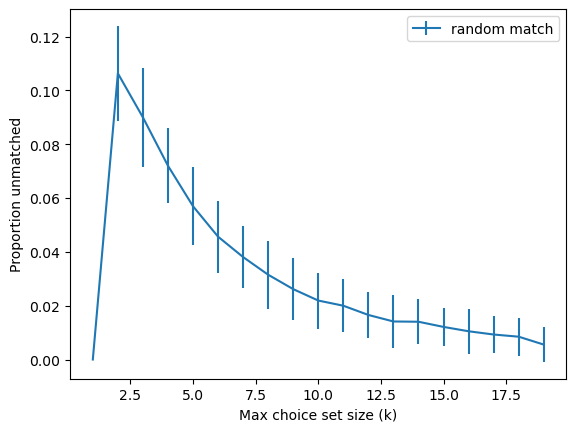

In [32]:
n = 99
N = 100
K = 20

plot_unmatched()